# Kings County Housing Prices Bakeoff

Below are a list of steps that you should take while trying to complete your bake-off entry.

## Read in Data and Packages

In [172]:
import pandas as pd
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 200)

import scipy
from scipy.stats import ttest_ind
from scipy.stats.stats import pearsonr

import numpy as np

from matplotlib import pyplot as plt

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

import seaborn as sns
from statsmodels.formula.api import ols
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
sns.set(style="whitegrid")
import seaborn as sns


In [173]:
df = pd.read_csv('kc_house_data_train.csv', index_col=0)

## Exploratory Data Analysis 
    
Become familiar with the data.  Look to see if there are any extreme values.  

Additionally create data visualizations to determine if there are any relationships between your features and your target variables.  

In [174]:
#Familiarizing myself with the dataframe, reviewing the columns 
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [175]:
#checking the shape of the data
df.shape

(17290, 21)

In [176]:
#checking for missing values by calculating the mean of each column. Because each column mean is equal 
#to 0 we can determine that there are no missing values in this data set
df.isna().mean()

id               0.0
date             0.0
price            0.0
bedrooms         0.0
bathrooms        0.0
sqft_living      0.0
sqft_lot         0.0
floors           0.0
waterfront       0.0
view             0.0
condition        0.0
grade            0.0
sqft_above       0.0
sqft_basement    0.0
yr_built         0.0
yr_renovated     0.0
zipcode          0.0
lat              0.0
long             0.0
sqft_living15    0.0
sqft_lot15       0.0
dtype: float64

## Clean up any issues (extreme values, etc.) with the data.  

Remember that you can't just delete rows with extreme values. Similar observations might be present in the holdout data set, and you can't just delete those rows and not have a prediction for it. 

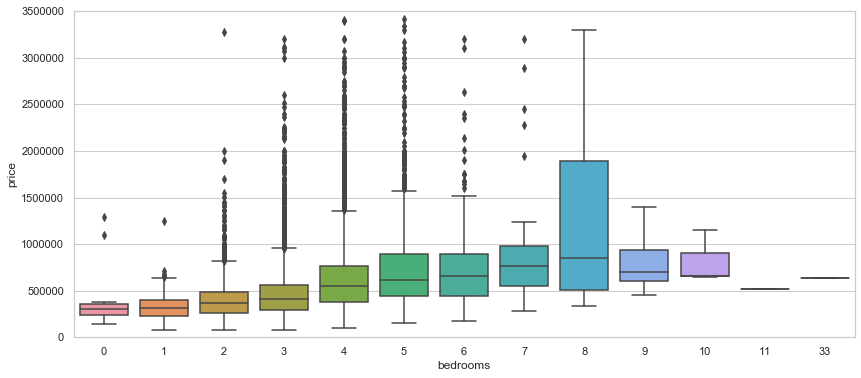

In [177]:
#I want to see if there are any extreme values in the 'bedrooms' column 
var = 'bedrooms'
data = pd.concat([df['price'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=3500000);

In [178]:
#I see the extreme value of 33. I researched these values and I reconciled the issue by I changing the variable 
#from 33 to 3 (from what I found on zillow after doing some research and discovering it was a typo). 

df['bedrooms']=df['bedrooms'].replace([33],3)

In [179]:
# I also want to investigate homes that have more than 10 rooms. These were multifamily homes so I will leave them.

df.loc[df['bedrooms'] >= 10]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2356,1773100755,20140821T000000,520000.0,11,3.00,3000,4960,2.0,0,0,3,7,2400,600,1918,1999,98106,47.5560,-122.363,1420,4960
3680,8812401450,20141229T000000,660000.0,10,3.00,2920,3745,2.0,0,0,4,7,1860,1060,1913,0,98105,47.6635,-122.320,1810,3745
11181,627300145,20140814T000000,1148000.0,10,5.25,4590,10920,1.0,0,2,3,9,2500,2090,2008,0,98004,47.5861,-122.113,2730,10400
17114,5566100170,20141029T000000,650000.0,10,2.00,3610,11914,2.0,0,0,4,7,3010,600,1958,0,98006,47.5705,-122.175,2040,11914


<function matplotlib.pyplot.show>

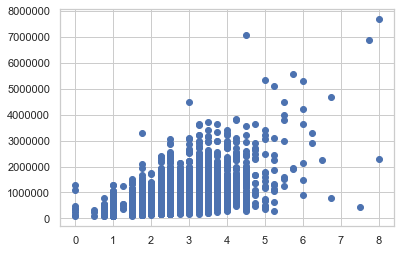

In [181]:
#I want to look at bathrooms next and see there are a few values. After some investigation I felt comfortable
#leaving the higher values alone.
x= df["bathrooms"]
y= df["price"]
plt.scatter(x,y)
plt.show

In [182]:
#However, I looked at the 0 bathroom values and treated them as quarter baths so it does not throw off my model
df.loc[df['bathrooms'] == 0] 
df['bathrooms'] = df['bathrooms'].replace([0],.25)

## Feature Engineering

After doing this, you will want to go back to steps 2 and 3 to investigate these new features.

In [184]:
#I reviewed the columns once more so I can create a features variable.
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [185]:
#I created a features variable so I can use in my heatmap to visualize collinearity. I also eliminated the columns
#ID and dates because they do not have bearing on the price of the house
features = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15']

df_features = df[features]

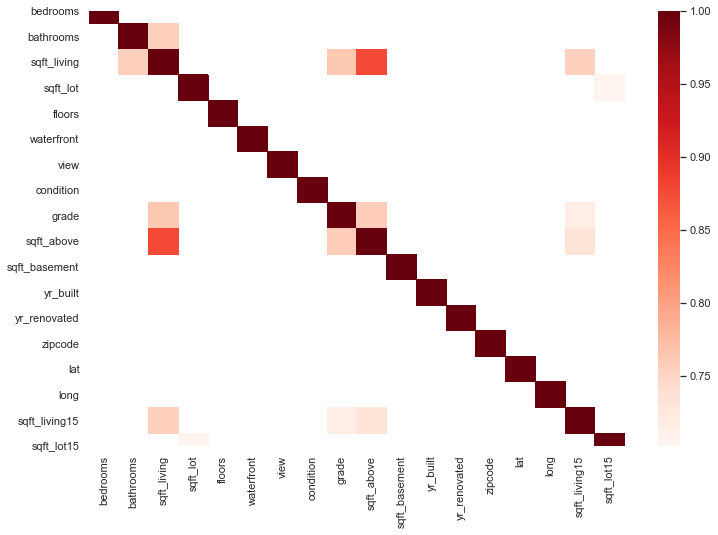

In [186]:
corr=df[features].corr()

kot = corr[corr>=.7]
plt.figure(figsize=(12,8))

sns.heatmap(kot, cmap="Reds")

In [187]:
#Looking at the heatmap I see there is collinearity between sqft_living and sqft_above. I want to eliminate one of 
#these columns because I don't want to have any variances inflated. I've identified high colinearity between 
#sqft_living  and sqft_basement. Because sqft_living incorporates sqft_basement and sqft_above I decide to drop 
#sqft_living

modeldf = df.drop(['sqft_living',], axis = 1)

In [188]:
#I am satisfied with the elimination of highly collinear features so now I want to begin creating additional features.
#I think it will be useful to have a binary feature of whether or not the home is a multi level home so I create a feature 
#that caputres this. 
modeldf['multilevel'] = np.where(modeldf['floors']> 1, 1, 0)
modeldf['multilevel'].value_counts()

1    8684
0    8606
Name: multilevel, dtype: int64

In [199]:
import scipy.stats as stats
#I want to find out if people who purchase multilevel homes spend spend the same amount as people who do not 
#purchase multilevel homes
#Ho: multilevel = not_multilevel
#Ha: multilevel =! not_multilevel

without_multilevel= modeldf[modeldf['multilevel'] == 0]['price']
with_multilevel = modeldf[modeldf['multilevel'] == 1]['price']
t, p =stats.ttest_ind(with_multilevel , without_multilevel, equal_var=True)


print (t, p)
p>.05

35.33932662389391 3.371727934496698e-264


False

In [200]:
#I am rejecting the null hypothesis that people who purchase multilevel homes spend the same amount as people who 
#purchase homes that are not multilevel

In [189]:
#I also want to create a column that tells me if the house has a basement

modeldf['basement'] = np.where(modeldf['sqft_basement']> 1, 1, 0)
modeldf['basement'].value_counts()

0    10484
1     6806
Name: basement, dtype: int64

In [203]:
#I want to find out if people who purchase homes with basements spend the same amount as people who purchase homes
#that do not have basements 
#Ho: with_basement = without_basement
#Ha: with_basement =! without basement

without_basement= modeldf[modeldf['basement'] == 0]['price']
with_basement = modeldf[modeldf['basement'] == 1]['price']
t, p =stats.ttest_ind(with_basement , without_basement, equal_var=True)
print(t,p)
p>.05

23.64189256331611 1.2107663322174255e-121


False

In [202]:
#I am rejecting the null hypothesis that people who purchase homes with basements spend the same amount as people who 
#purchase homes without basements

In [204]:
#I want to find out if people who purchase waterfront homes spend the same amount as people who purchase non waterfront
#homes 
#Ho: waterfront = not_waterfront
#Ha: waterfront =! not_waterfront

not_waterfront= modeldf[modeldf['waterfront'] == 0]['price']
waterfront = modeldf[modeldf['waterfront'] == 1]['price']
t, p =stats.ttest_ind(waterfront , not_waterfront, equal_var=True)
print(t,p)
p>.05

37.72330429549608 2.465038317654299e-299


False

In [205]:
#I am rejecting the null hypothesis that people who purchase waterfront homes spend the same amount as people who 
#purchase non waterfront homes

In [206]:
#Outdoor space is important in urban and suburban areas so I want to create a feature that can capture that.
#I used sqft_lot (total lot space) and subtracted that from sqft_above (which is the area without the basement) and 
#divided the amount of floors the house has to get the feature outdoor_space. After runninh cell 28 I noticed the 
#min was a negative number. I identified which row had the negative output and conducted additional research. 
#I learned the house this was referring to had a sq_ft of 1200. I looked back in the data and made sure there were 
#no other variables that had an 1105 sq_ft value and when I was sure it was just that one, I replaced it with 1200
#and reran the code. 
modeldf.replace({'sqft_lot': {1105: 1200}}, inplace=True)

In [207]:
modeldf['outdoor_space'] = modeldf['sqft_lot'] - (modeldf['sqft_above']/modeldf['floors'])
modeldf['outdoor_space'].describe()

count    1.729000e+04
mean     1.400310e+04
std      4.221535e+04
min      2.166667e+01
25%      4.020750e+03
50%      6.396000e+03
75%      9.344000e+03
max      1.650059e+06
Name: outdoor_space, dtype: float64

In [208]:
#Another factor that increases house prices is if the house has newer amenities. I created a feature called 'modern'
#which includes houses that were built on or after 2004 (10 years prior to this data being collected) and those that
#have been updated on or after 2001. 

modeldf['modern'] = np.where((modeldf['yr_built']>= 2004)|(modeldf['yr_renovated']>=2001), 1, 0)
modeldf['modern'].value_counts()

0    14140
1     3150
Name: modern, dtype: int64

In [209]:
#After creating these new features, I wanted to check for collinearity once more and take my new columns and create
#a features variable again. 
modeldf.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'multilevel', 'basement',
       'outdoor_space', 'modern'],
      dtype='object')

In [210]:
features = ['bedrooms', 'bathrooms', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'multilevel', 'basement',
       'outdoor_space', 'modern']

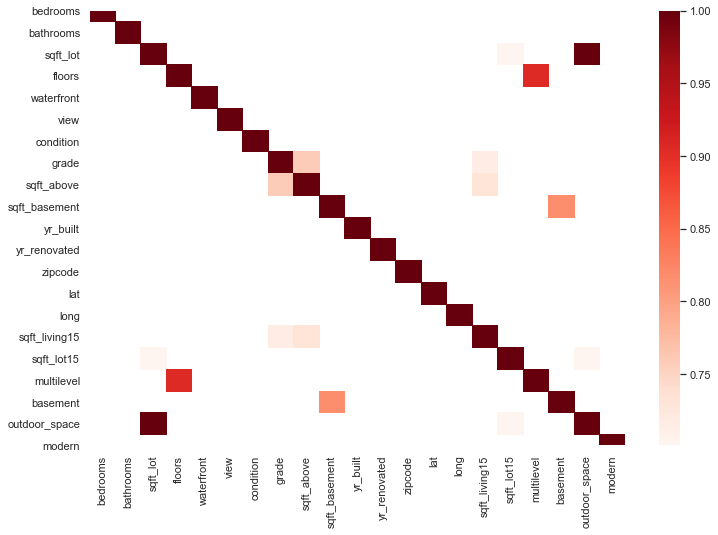

In [211]:
corr=modeldf[features].corr()

kot = corr[corr>=.7]
plt.figure(figsize=(12,8))

sns.heatmap(kot, cmap="Reds")

In [212]:
#I am seeing a lot of collinearity so I dropped the following features:

#eliminating SQFT_LOT because it has high collinearity with outdoor_space and it incorporates other features like 
#sqft_above
#Eliminating FLOORS because there is high collinearity with multilevel. Whether or not the house is multilevel is 
#more important for my model than the number of floors it has 
#Eliminating SQFT_BASEMENT because there is collinearity with basement. Whether or not the house has a basement is 
#important for my model than the SQFT_Basement
#Eliminating grade because of its high collinearity with sqft_above 
#Eliminating sqft_lot15
#Eliminating sqft_living15

modeldf = modeldf.drop(['id', 'date','sqft_lot', 'floors', 'sqft_basement', 'grade', 'sqft_lot15', 'sqft_living15'], axis=1)
modeldf

,price,bedrooms,bathrooms,waterfront,view,condition,sqft_above,yr_built,yr_renovated,zipcode,lat,long,multilevel,basement,outdoor_space,modern
0,365000.0,4,2.25,0,0,4,2070,1986,0,98058,47.4388,-122.162,1,0,7858.000000,0
1,865000.0,5,3.00,0,0,5,1830,1977,0,98115,47.6784,-122.285,0,1,4900.000000,0
2,1038000.0,4,2.50,0,2,3,3770,1997,0,98006,47.5646,-122.129,1,0,9008.000000,0
3,1490000.0,3,3.50,0,2,3,4560,1990,0,98034,47.6995,-122.228,1,0,12328.000000,0
4,711000.0,3,2.50,0,0,3,2550,2004,0,98052,47.6647,-122.083,1,0,4101.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,750000.0,5,2.50,0,1,3,2020,1958,0,98008,47.5858,-122.112,0,1,7940.000000,0
17286,440000.0,2,1.75,0,0,3,1300,1948,0,98105,47.6687,-122.288,1,0,3350.000000,0
17287,310000.0,3,1.00,0,0,3,1050,1953,0,98028,47.7635,-122.262,0,0,8826.000000,0
17288,427500.0,3,1.50,0,0,4,1300,1971,0,98038,47.4199,-121.990,1,1,42319.333333,0


In [213]:
# To make sure that I get a line of best fit for my outdoor_space continuous variable I want to create a polynomial
modeldf['outdoor_space^2'] = modeldf['outdoor_space']*modeldf['outdoor_space']

In [214]:
#I am also interested in how particular features interact. So I created the below features. 
modeldf['sqft_view'] = modeldf['sqft_above']*modeldf['view']
modeldf['sqft_multilevel'] = modeldf['sqft_above']*modeldf['multilevel']
modeldf['outdoor_modern'] = modeldf['outdoor_space']*modeldf['modern']
modeldf['outdoorspace_waterfront'] = modeldf['outdoor_space']*modeldf['waterfront']

In [215]:
modeldf.shape

(17290, 21)

In [216]:
modeldf.columns

Index(['price', 'bedrooms', 'bathrooms', 'waterfront', 'view', 'condition',
       'sqft_above', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'multilevel', 'basement', 'outdoor_space', 'modern', 'outdoor_space^2',
       'sqft_view', 'sqft_multilevel', 'outdoor_modern',
       'outdoorspace_waterfront'],
      dtype='object')

In [217]:
#Repeating the above step to find collinearity
features = ['bedrooms', 'bathrooms', 'waterfront', 'view',
       'condition', 'sqft_above', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
       'long', 'multilevel', 'basement', 'outdoor_space', 'modern',
       'outdoor_space^2', 'sqft_view', 'sqft_multilevel', 'outdoor_modern',
       'outdoorspace_waterfront']

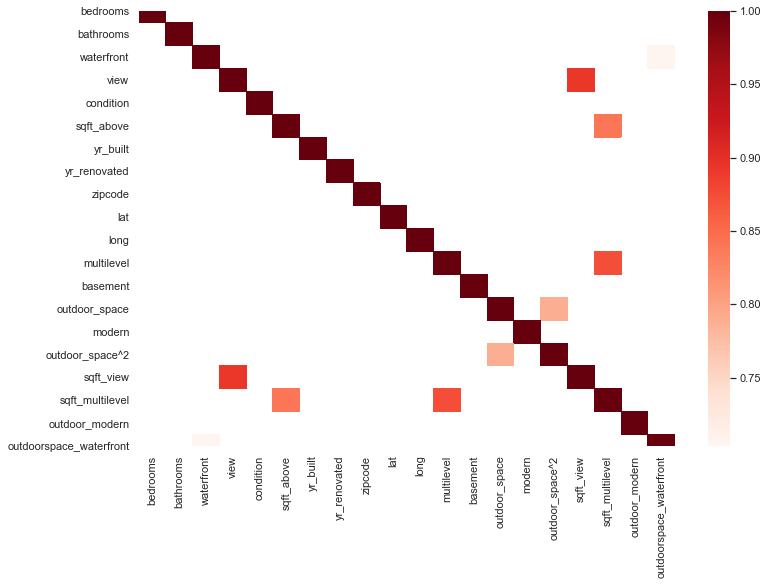

In [218]:
corr=modeldf[features].corr()

kot = corr[corr>=.7]
plt.figure(figsize=(12,8))

sns.heatmap(kot, cmap="Reds")

In [219]:
#I see that some of my ineractions have high collinearity so I dropped them 
modeldf = modeldf.drop(['sqft_view','sqft_multilevel','outdoor_space^2'], axis=1)
modeldf

,price,bedrooms,bathrooms,waterfront,view,condition,sqft_above,yr_built,yr_renovated,zipcode,lat,long,multilevel,basement,outdoor_space,modern,outdoor_modern,outdoorspace_waterfront
0,365000.0,4,2.25,0,0,4,2070,1986,0,98058,47.4388,-122.162,1,0,7858.000000,0,0.0,0.0
1,865000.0,5,3.00,0,0,5,1830,1977,0,98115,47.6784,-122.285,0,1,4900.000000,0,0.0,0.0
2,1038000.0,4,2.50,0,2,3,3770,1997,0,98006,47.5646,-122.129,1,0,9008.000000,0,0.0,0.0
3,1490000.0,3,3.50,0,2,3,4560,1990,0,98034,47.6995,-122.228,1,0,12328.000000,0,0.0,0.0
4,711000.0,3,2.50,0,0,3,2550,2004,0,98052,47.6647,-122.083,1,0,4101.000000,1,4101.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,750000.0,5,2.50,0,1,3,2020,1958,0,98008,47.5858,-122.112,0,1,7940.000000,0,0.0,0.0
17286,440000.0,2,1.75,0,0,3,1300,1948,0,98105,47.6687,-122.288,1,0,3350.000000,0,0.0,0.0
17287,310000.0,3,1.00,0,0,3,1050,1953,0,98028,47.7635,-122.262,0,0,8826.000000,0,0.0,0.0
17288,427500.0,3,1.50,0,0,4,1300,1971,0,98038,47.4199,-121.990,1,1,42319.333333,0,0.0,0.0


In [220]:
#Finally, location of houses effects price so I want to create dummy variables that capture that  and concat it to 
#my model dataframe 
modeldf_dum = pd.get_dummies(modeldf['zipcode'])
modeldf = pd.concat([modeldf, modeldf_dum], axis=1)
modeldf.head()

,price,bedrooms,bathrooms,waterfront,view,condition,sqft_above,yr_built,yr_renovated,zipcode,lat,long,multilevel,basement,outdoor_space,modern,outdoor_modern,outdoorspace_waterfront,98001,98002,98003,98004,98005,98006,98007,98008,98010,98011,98014,98019,98022,98023,98024,98027,98028,98029,98030,98031,98032,98033,98034,98038,98039,98040,98042,98045,98052,98053,98055,98056,98058,98059,98065,98070,98072,98074,98075,98077,98092,98102,98103,98105,98106,98107,98108,98109,98112,98115,98116,98117,98118,98119,98122,98125,98126,98133,98136,98144,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,365000.0,4,2.25,0,0,4,2070,1986,0,98058,47.4388,-122.162,1,0,7858.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,865000.0,5,3.00,0,0,5,1830,1977,0,98115,47.6784,-122.285,0,1,4900.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1038000.0,4,2.50,0,2,3,3770,1997,0,98006,47.5646,-122.129,1,0,9008.0,0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1490000.0,3,3.50,0,2,3,4560,1990,0,98034,47.6995,-122.228,1,0,12328.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,711000.0,3,2.50,0,0,3,2550,2004,0,98052,47.6647,-122.083,1,0,4101.0,1,4101.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [221]:
modeldf.shape

(17290, 88)

In [222]:
modeldf.columns

Index([                  'price',                'bedrooms',
                     'bathrooms',              'waterfront',
                          'view',               'condition',
                    'sqft_above',                'yr_built',
                  'yr_renovated',                 'zipcode',
                           'lat',                    'long',
                    'multilevel',                'basement',
                 'outdoor_space',                  'modern',
                'outdoor_modern', 'outdoorspace_waterfront',
                           98001,                     98002,
                           98003,                     98004,
                           98005,                     98006,
                           98007,                     98008,
                           98010,                     98011,
                           98014,                     98019,
                           98022,                     98023,
                        

In [223]:
#Now that I have my features I add them to my features variable, create a target variable to use in my train test split
#and check the length of the features
features = ['bedrooms','bathrooms','waterfront','view','condition','sqft_above','yr_built','yr_renovated','zipcode',
           'lat','long','multilevel','basement','outdoor_space','modern','outdoor_modern','outdoorspace_waterfront', 
           98001, 98002, 98003, 98004, 98005, 98006, 98007, 98008, 98010, 98011, 98014, 98019, 98022, 98023, 98024,
           98027, 98028, 98029, 98030, 98031, 98032, 98033, 98034, 98038, 98039, 98040, 98042, 98045, 98052, 98053,
            98055, 98056, 98058, 98059, 98065, 98070, 98072, 98074, 98075, 98077, 98092, 98102, 98103, 98105, 98106,
            98107, 98108, 98109, 98112, 98115, 98116, 98117, 98118, 98119, 98122, 98125, 98126, 98133, 98136, 98144,
            98146, 98148, 98155, 98166, 98168, 98177, 98178, 98188, 98198, 98199]
df_features = modeldf[features]

target = modeldf['price']
len(features)

87

In [224]:
#Splitting my data so I can train my model and test it
X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=9, test_size=.25)

In [225]:
# Here I am instantiating a linear regression object then fitting the linear regression to the training and testing
#data set

lm = LinearRegression()

lm = lm.fit(X_train, y_train)

y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)

In [226]:
#I now evaluate the predictions on my training and test sets. The below output is showing that I am within the
#the target range (under 200k). My model is not overfitted to the training set because the Training RMSE isn't 
#significantly lower than the Testing RMSE
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print('Training Root Mean Squared Error:' , train_rmse)
print('Testing Root Mean Squared Error:' , test_rmse)

Training Root Mean Squared Error: 174497.77712363945
Testing Root Mean Squared Error: 169835.59567466806


# Select KBest

In [227]:
#I want to see if I can get a better RMSE than my previous model so I use SelectKBest to do feature selection
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
selector = SelectKBest(f_regression, k=30)
selector.fit(X_train, y_train)

SelectKBest(k=30, score_func=<function f_regression at 0x7f87eeb33158>)

In [228]:
#I create variables for the selected columns and the removed columns 
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [229]:
#Select KBest removed 57 columns
len(removed_columns)

57

In [230]:
#And kept 30 columns
len(selected_columns)

30

In [231]:
#Now I fit the model to the training and test sets
lm_kbest = LinearRegression()
lm_kbest.fit(X_train[selected_columns],y_train)

y_train_kbest = lm_kbest.predict(X_train[selected_columns])
trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))

#And find the RMSE
y_kbest = lm_kbest.predict(X_test[selected_columns])
testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))
print('Training RMSE:', trainK_rmse)
print('Testing RMSE:', testK_rmse)

#This RMSE looks higher than my model RMSE. 

Training RMSE: 194399.14065785264
Testing RMSE: 190788.4889083355


# Recursive Feature Elimination

In [232]:
#I will try to try to do one more feature selection 
from sklearn.feature_selection import RFECV

In [233]:
ols = linear_model.LinearRegression()

In [234]:
selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
selector.fit(X_train, y_train)

Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.


RFECV(cv=5,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=-1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [235]:
selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]

In [236]:
#I review the variables that RFE has removed
list(removed_rfe)

['outdoor_space', 'outdoor_modern', 'outdoorspace_waterfront']

In [237]:
#and look at the length of the selected features
len(list(selected_rfe))

84

In [238]:
selected_rfe

Index([    'bedrooms',    'bathrooms',   'waterfront',         'view',
          'condition',   'sqft_above',     'yr_built', 'yr_renovated',
            'zipcode',          'lat',         'long',   'multilevel',
           'basement',       'modern',          98001,          98002,
                98003,          98004,          98005,          98006,
                98007,          98008,          98010,          98011,
                98014,          98019,          98022,          98023,
                98024,          98027,          98028,          98029,
                98030,          98031,          98032,          98033,
                98034,          98038,          98039,          98040,
                98042,          98045,          98052,          98053,
                98055,          98056,          98058,          98059,
                98065,          98070,          98072,          98074,
                98075,          98077,          98092,          98102,
      

In [239]:
lm_rfe = LinearRegression()

lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)
y_rfe = lm_rfe.predict(X_train[selected_rfe])

trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))

y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])
testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))

print ('Training Root Mean Squared Error:', trainRFE_rmse)
print ('Testing Root Mean Squared Error:', testRFE_rmse)

Training Root Mean Squared Error: 174990.60203402015
Testing Root Mean Squared Error: 168544.40012797917


## Evaluate your different models in order to determine the best model overall.

In [240]:
print('Original:', test_rmse)
print('KBest:', testK_rmse)
print('RFE', testRFE_rmse)

Original: 169835.59567466806
KBest: 190788.4889083355
RFE 168544.40012797917


## Refit the best model to the entire dataset.

In [241]:
modeldf[selected_rfe].describe()

,bedrooms,bathrooms,waterfront,view,condition,sqft_above,yr_built,yr_renovated,zipcode,lat,long,multilevel,basement,modern,98001,98002,98003,98004,98005,98006,98007,98008,98010,98011,98014,98019,98022,98023,98024,98027,98028,98029,98030,98031,98032,98033,98034,98038,98039,98040,98042,98045,98052,98053,98055,98056,98058,98059,98065,98070,98072,98074,98075,98077,98092,98102,98103,98105,98106,98107,98108,98109,98112,98115,98116,98117,98118,98119,98122,98125,98126,98133,98136,98144,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
count,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.00000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000
mean,3.370735,2.112059,0.007981,0.238519,3.408502,1789.306015,1970.792019,83.806304,98078.193175,47.560058,-122.214258,0.502256,0.393638,0.182186,0.016426,0.00908,0.012955,0.013707,0.008097,0.022267,0.007056,0.013071,0.004280,0.009427,0.005842,0.008386,0.010931,0.023713,0.003759,0.019202,0.012666,0.014459,0.011625,0.012435,0.005957,0.020532,0.025159,0.026316,0.002429,0.013245,0.024465,0.010179,0.027415,0.018739,0.012146,0.019433,0.022267,0.021573,0.014401,0.005726,0.012435,0.020706,0.016541,0.009370,0.016541,0.004627,0.026663,0.009832,0.015385,0.012261,0.008733,0.004916,0.012493,0.026894,0.015385,0.025275,0.023713,0.008618,0.013592,0.018566,0.016079,0.023135,0.012377,0.015558,0.014228,0.002487,0.020243,0.012088,0.012435,0.012608,0.012435,0.006304,0.012724,0.015385
std,0.911923,0.770178,0.088985,0.775229,0.651296,829.265107,29.343516,400.329376,53.607949,0.138412,0.140857,0.500009,0.488570,0.386009,0.127109,0.09486,0.113086,0.116277,0.089622,0.147556,0.083706,0.113583,0.065283,0.096639,0.076209,0.091195,0.103982,0.152158,0.061200,0.137238,0.111833,0.119377,0.107195,0.110820,0.076955,0.141816,0.156613,0.160077,0.049228,0.114324,0.154492,0.100381,0.163293,0.135606,0.109540,0.138046,0.147556,0.145289,0.119142,0.075455,0.110820,0.142401,0.127549,0.096345,0.127549,0.067866,0.161101,0.098672,0.123080,0.110054,0.093046,0.069945,0.111074,0.161779,0.123080,0.156963,0.152158,0.092433,0.115792,0.134989,0.125782,0.150336,0.110565,0.123762,0.118432,0.049809,0.140834,0.109282,0.110820,0.111580,0.110820,0.079151,0.112085,0.123080
min,0.000000,0.250000,0.000000,0.000000,1.000000,290.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.500000,0.000000,0.000000,3.000000

In [242]:
final_scaler = StandardScaler()

df_final_scaled = pd.DataFrame(data=final_scaler.fit_transform(modeldf[selected_rfe]), columns=selected_rfe)


In [243]:
df_final_scaled.shape

(17290, 84)

In [244]:
selected_rfe

Index([    'bedrooms',    'bathrooms',   'waterfront',         'view',
          'condition',   'sqft_above',     'yr_built', 'yr_renovated',
            'zipcode',          'lat',         'long',   'multilevel',
           'basement',       'modern',          98001,          98002,
                98003,          98004,          98005,          98006,
                98007,          98008,          98010,          98011,
                98014,          98019,          98022,          98023,
                98024,          98027,          98028,          98029,
                98030,          98031,          98032,          98033,
                98034,          98038,          98039,          98040,
                98042,          98045,          98052,          98053,
                98055,          98056,          98058,          98059,
                98065,          98070,          98072,          98074,
                98075,          98077,          98092,          98102,
      

## Saving final model using pickle.

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [245]:
import pickle 

pickle_out = open('scaler.pickle', "wb")
pickle.dump(df_final_scaled, pickle_out)
pickle_out.close()

In [246]:
lm_rfe = LinearRegression()

lm_rfe = lm_rfe.fit(modeldf[selected_rfe], df['price'])

In [247]:
pickle_out = open('model.pickle', "wb")
pickle.dump(lm_rfe, pickle_out)
pickle_out.close()